# A computational deep learning investigation of animacy perception in the human brain

# 1. FINETUNE MODEL

## Intro

### Fine-tuning a Pretrained AlexNet on a Custom Two-Class Dataset

This script demonstrates how to fine-tune a pretrained AlexNet neural network on a custom dataset
with only two categories. All layers except FC7 and the output layer are frozen. The learning rate
starts at 0.01 and gradually multiplies with a factor of 0.1 if the validation loss does not improve
over 5 consecutive epochs, with a minimum learning rate of 0.00001. The batch size is set to 20, and
the training is run for 500 epochs. We use the SGD optimization algorithm, cross-entropy loss
function, momentum of 0.9, and shuffle the data each epoch.

### Obtaining a correlation matrix

The second part of the script uses the trained model and a novel test set to obtain image vectors from the output layer. The image vectors are correlated with each other and the resulting dissimilarity matrix is displayed. 

### Check this before running the code :)
Download, extract and save the dataset: https://osf.io/t6apv

Dowload and save the pth weights file for the model finetuned in this script: https://osf.io/yk7jf


## Set dir

In [21]:
# Specify the path to your custom dataset directory
#data_dir = '/path/to/your/dataset/'
data_dir = '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset'
#pth_dir = 'path_to_finetuned_model.pth'
pth_dir = '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/OSF_modeltesting/weights/animalbias/alexnet/best_model_weights.pth'


## Imports

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import time
import copy
import os
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from PIL import Image
from torch.autograd import Variable

## Define the data transforms for training, validation and testing


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
        transforms.RandomRotation(5), 
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(224), #imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([ #validation does not use augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Load the data

In [7]:
# Create data loaders for training, validation and testing using ImageFolder
train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'train'),
    data_transforms['train']
)

val_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'val'),
    data_transforms['val']
)

test_dataset = datasets.ImageFolder(
    os.path.join(data_dir, 'test'),
    data_transforms['test']
)


## Set model specs

In [8]:
batch_size = 20
num_epochs = 500


## Create data loaders for training and validation

In [9]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True),
}

## Load the pre-trained AlexNet model

In [10]:
model = models.alexnet(pretrained=True)

## Prepare model

In [11]:
# Freeze all layers except FC7 and the output layer
for name, param in model.named_parameters():
    if name not in ['classifier.6.weight', 'classifier.6.bias']:
        param.requires_grad = False

# Modify the last fully connected layer for 2 classes
model.classifier[6] = nn.Linear(4096, 2)

# Set up the optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, min_lr=0.00001)

# Define the loss function
criterion = nn.CrossEntropyLoss()


## Training loop

In [12]:
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        for inputs, labels in dataloaders[phase]:
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = corrects.double() / len(dataloaders[phase].dataset)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val':
            scheduler.step(epoch_loss)

            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    print()

# Load the best model weights
model.load_state_dict(best_model_wts)


Epoch 0/499
----------
train Loss: 1.4671 Acc: 0.7761
val Loss: 1.6750 Acc: 0.8409

Epoch 1/499
----------
train Loss: 2.3891 Acc: 0.8532
val Loss: 1.6083 Acc: 0.8864

Epoch 2/499
----------
train Loss: 0.9226 Acc: 0.9204
val Loss: 1.7500 Acc: 0.8864

Epoch 3/499
----------
train Loss: 0.9131 Acc: 0.9179
val Loss: 1.7118 Acc: 0.9091

Epoch 4/499
----------
train Loss: 0.7218 Acc: 0.9502
val Loss: 1.1985 Acc: 0.9091

Epoch 5/499
----------
train Loss: 0.5775 Acc: 0.9403
val Loss: 1.0406 Acc: 0.9545

Epoch 6/499
----------
train Loss: 0.7543 Acc: 0.9527
val Loss: 1.2973 Acc: 0.9318

Epoch 7/499
----------
train Loss: 0.4917 Acc: 0.9502
val Loss: 0.7999 Acc: 0.8864

Epoch 8/499
----------
train Loss: 0.6451 Acc: 0.9552
val Loss: 1.6564 Acc: 0.9318

Epoch 9/499
----------
train Loss: 0.6520 Acc: 0.9478
val Loss: 2.3599 Acc: 0.8864

Epoch 10/499
----------
train Loss: 0.7272 Acc: 0.9403
val Loss: 2.3302 Acc: 0.8864

Epoch 11/499
----------
train Loss: 2.0972 Acc: 0.9179
val Loss: 3.2958 Acc

KeyboardInterrupt: 

# 2. EVALUATE MODEL WITH TEST SET AND OBTAIN CORRELATION MATRIX FROM OUTPUT LAYER

In [70]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

*** 

In [71]:
# Comment this piece if you wish to continue with model trained in previous cell
#this part will load the pth weights file from the authors:
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Adjust this line based on your model architecture
checkpoint = torch.load(pth_dir)
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

***

In [ ]:
model.eval()

In [62]:
image_dirs = list()
temp_list = list()
    
for path, subdirs, files in os.walk(os.path.join(data_dir, 'test')):
    #First path is just val folder, so exclude this
    if subdirs == []:
        for name in sorted(files):
            # save image paths per species in list
            temp_list.append(os.path.join(path, name))
        image_dirs.append(temp_list)
        temp_list = list() #empty temp_list

image_dirs.reverse()        
#image_dirs must be in the order of 1animate, 2lookalike, 3inanimate
print(image_dirs)     

[['/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/1C_Groenling_M_3 .png', '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/3C_Citroenkwikstaart_2 .png', '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/42504623ac2ada66512a9a84e1932e83.jpg', '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/4A_Zilverplevier_Z_4 .png', '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/6874f9a5e1c832f87c330e0f80db4e75.jpg', '/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/download (14).jpg', '/Users/duyckstefanie/Libr

In [63]:
layer_of_extraction = model.classifier[6]
num_nodes_fc8 = len(checkpoint['model_state_dict']['classifier.6.weight'])
print (num_nodes_fc8) #get number of output nodes in FC8

# Transform & make tensor
scaler = transforms.Resize(224)
to_tensor = transforms.ToTensor()
#The last transform ‘to_tensor’ will be used to convert the PIL image to a PyTorch tensor (multidimensional array).
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    

2


In [64]:
def get_vector(image_name, nodesfc8):
        # 1. Load the image with Pillow library
        img = Image.open(image_name).convert('RGB')
        print(image_name)
        
        # 2. Create a PyTorch Variable with the transformed image
        t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)) 
        
        # 3. Create a vector of zeros that will hold our feature vector
        my_embedding = torch.zeros(1, nodesfc8)   

        # 4. Define a function that will copy the output of a layer
        def copy_data(m, i, o):
            my_embedding.copy_(o.data) 
    
        # 5. Attach that function to our selected layer
        h = layer_of_extraction.register_forward_hook(copy_data) 
        
        # 6. Run the model on our transformed image
        model(t_img) 
        
        # 7. Detach our copy function from the layer
        h.remove()   
        
        # 8. Return the feature vector
        return my_embedding #.data.numpy().astype(DTYPE)
    

In [65]:
save_vectors = [] 
save_imagenames = []
matrix = np.zeros([99,99]) #create empty matrix to store results
for species in range(3): # row index species,   
    for image in range(33): #row and 
        image_path = image_dirs[species][image]
        vector = get_vector(image_path, num_nodes_fc8) #Get vector of first image
        vector = torch.flatten(vector)
        
        save_imagenames.append(image_path)
        save_vectors.append(np.array(vector))
     
test3 = np.array(save_vectors).T
vector_df = pd.DataFrame(test3) #save the exact output vector for each image
imagenames_df = pd.DataFrame(save_imagenames)

#now I have a column for each image; and the rows are the image vectors/activations from the output layer for that image
RDM = 1 - vector_df.corr() #calc dissimilarity score
RDM_df = pd.DataFrame(RDM) #transform to dataframe
    

/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/1C_Groenling_M_3 .png
/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/3C_Citroenkwikstaart_2 .png
/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/42504623ac2ada66512a9a84e1932e83.jpg
/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/4A_Zilverplevier_Z_4 .png
/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/6874f9a5e1c832f87c330e0f80db4e75.jpg
/Users/duyckstefanie/Library/CloudStorage/OneDrive-KULeuven/Documents/Study4_forsharing/DATASETS/animal_bias_dataset/test/1animate/download (14).jpg
/Users/duyckstefanie/Library/CloudStorage/OneD

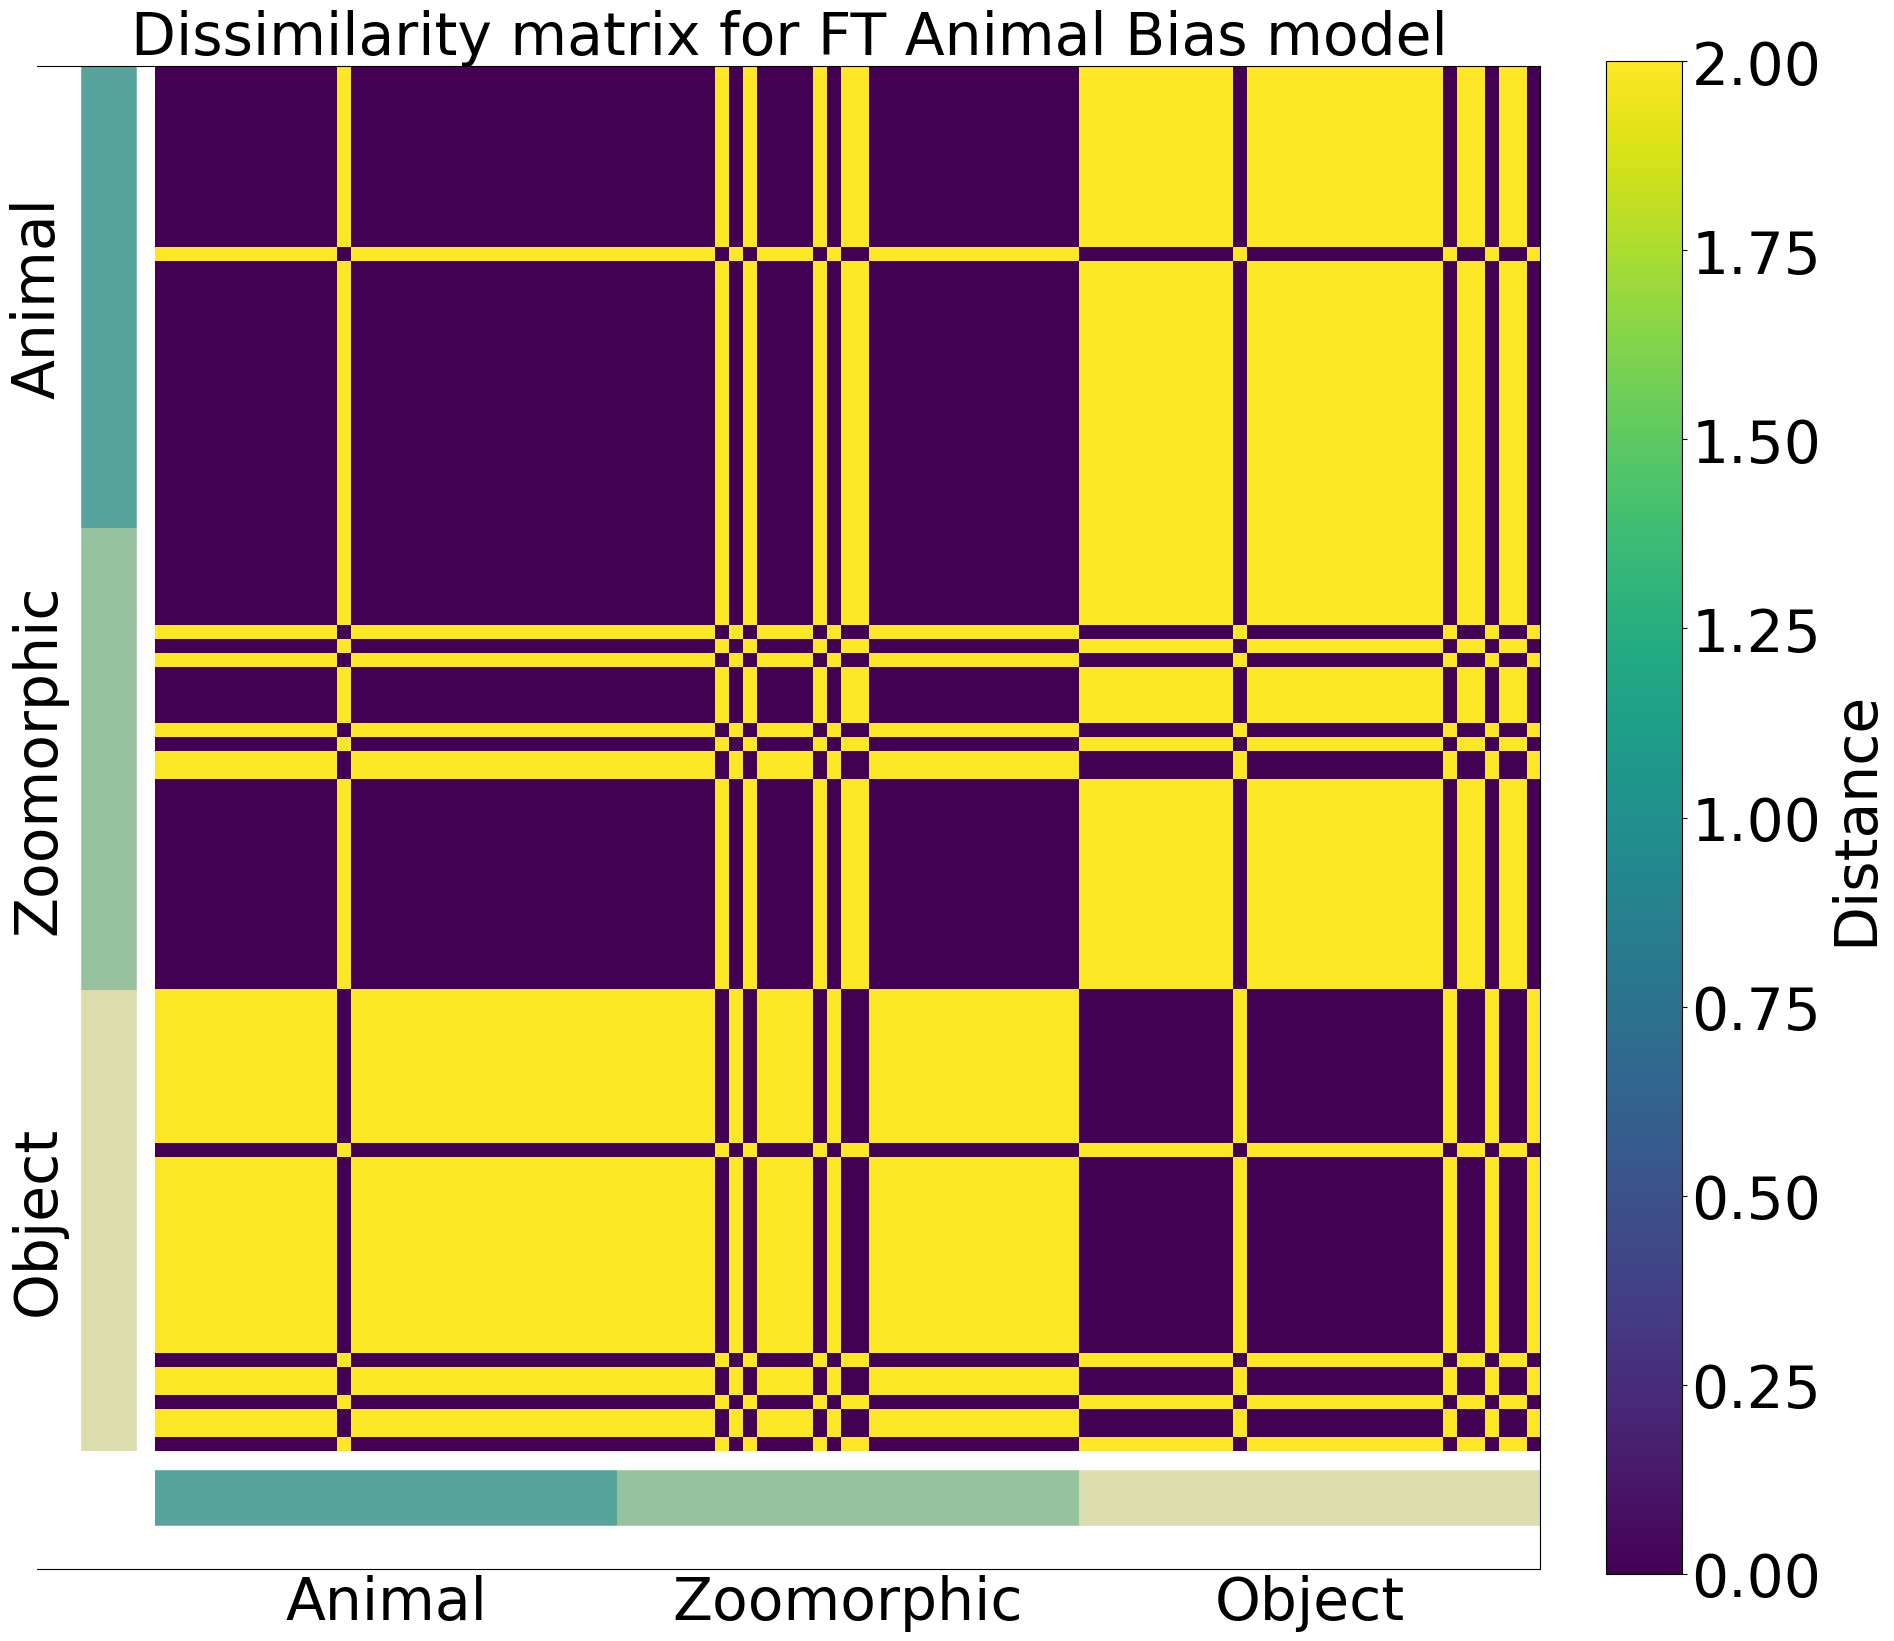

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [67]:
fig, ax = plt.subplots(figsize=(20,20))
fontsize = 42
Labels = ["Animal", "Zoomorphic", "Object"] #labels of the num_categories

plt.setp(ax.get_yticklabels(), fontsize=fontsize)
#plt.rcParams["font.family"] = "Calibri"
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure titl

im = ax.imshow(RDM, cmap='viridis', extent = [0,3,0,3])

# We want to show all ticks...
ax.set_xticks(np.arange(0.5,3,1))
ax.set_yticks(np.arange(0.5,3,1))

# ... and label them with the respective list entries
ax.set_xticklabels(Labels)
ax.set_yticklabels(np.flip(Labels))

#title above plot:
plt.title('Dissimilarity matrix for FT Animal Bias model', fontsize = fontsize)   

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_yticklabels(), rotation=90, 
         fontsize=fontsize, rotation_mode="anchor", ha="center")
plt.setp(ax.get_xticklabels(), 
         fontsize=fontsize, rotation_mode="anchor", ha="center")
ax.tick_params(length=0, width=0)

#add categorie boundaries
colors2 = ['#57a49c', '#97c29f', '#dcddad']
ax.hlines(y=-0.1, xmin=0, xmax=1, linewidth=40, color=colors2[0])
ax.hlines(y=-0.1, xmin=1, xmax=2, linewidth=40, color=colors2[1])
ax.hlines(y=-0.1, xmin=2, xmax=3, linewidth=40, color=colors2[2])

ax.vlines(x=-0.1, ymin=0, ymax=1, linewidth=40, color=colors2[2])
ax.vlines(x=-0.1, ymin=1, ymax=2, linewidth=40, color=colors2[1])
ax.vlines(x=-0.1, ymin=2, ymax=3, linewidth=40, color=colors2[0])


cb = fig.colorbar(im, fraction=0.046, pad=0.04)
cb.ax.tick_params(labelsize=fontsize)
cb.ax.set_ylabel('Distance', rotation=90)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    plt.tight_layout()   
    #plt.savefig(os.path.join(pathway, title + '.jpg'), bbox_inches='tight', dpi = 600)
    plt.show()